In [167]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
torch.set_default_dtype(torch.float64)
def _toN(x):
    return x.cpu().detach().numpy()

# https://journals.aps.org/prd/pdf/10.1103/PhysRevD.98.046019

d=3 # CFT dimension
L=1 # AdS radius
m2=-1 # mass^2
eta0=1 # initial radius, the regularized cutoff of asymptotic AdS
etaf=.1 # final radius, the horizon cutoff
N_segment=20 # number of segments
c_reg=1e-4 # different convention with paper
F_cutoff=1 # cutoff for the final F

# convert to torch tensor
d=torch.tensor(d,dtype=torch.float)
L=torch.tensor(L,dtype=torch.float)
m2=torch.tensor(m2,dtype=torch.float)
eta0=torch.tensor(eta0,dtype=torch.float)
etaf=torch.tensor(etaf,dtype=torch.float)
N_segment=torch.tensor(N_segment,dtype=torch.long)
c_reg=torch.tensor(c_reg,dtype=torch.float)


deta=(etaf-eta0)/N_segment # radius step
etas=torch.linspace(eta0,etaf,N_segment+1) # radius grid
etas_mid=(etas[1:]+etas[:-1])/2 # mid radius grid
DeltaPlus=d/2+torch.sqrt(d**2/4+m2*L**2)
DeltaMinus=d/2-torch.sqrt(d**2/4+m2*L**2)
# phi0=J*torch.exp(-DeltaMinus*eta0)+O*torch.exp(-DeltaPlus*eta0)/(DeltaPlus-DeltaMinus)
# pi0=-J*DeltaMinus*torch.exp(-DeltaMinus*eta0)-O*DeltaPlus*torch.exp(-DeltaPlus*eta0)/(DeltaPlus-DeltaMinus)
responseMap=torch.tensor([[torch.exp(-DeltaMinus*eta0),torch.exp(-DeltaPlus*eta0)/(DeltaPlus-DeltaMinus)],
                            [-DeltaMinus*torch.exp(-DeltaMinus*eta0),DeltaPlus*torch.exp(-DeltaPlus*eta0)/(DeltaPlus-DeltaMinus)]],dtype=torch.get_default_dtype())



#  asymptotically h[eta] ~= d/L

# note that phi,pi are batched

def dVdphiFunc(phi):
    mylambda=1
    # V=mylambda/4 phi**4
    return mylambda*phi**3

def forward(phi,pi,hs):
    for h in hs:
        phi,pi=phi+deta*pi,\
                pi-deta*(h*pi-m2*phi-dVdphiFunc(phi))
    return phi,pi

def get_initial_data(J,O):
    phi0,pi0=torch.matmul(responseMap,torch.stack([J,O]))
    return phi0,pi0

def classify_final_data(phi,pi):
    F=2/etaf*pi-m2*phi-dVdphiFunc(phi)
    return torch.tanh(torch.abs(F)/F_cutoff)

def get_regularizator_terms(hs):
    dhdeta=(hs[1:]-hs[:-1])/torch.abs(deta)
    dhdeta=torch.cat([dhdeta,dhdeta[-1:]])
    return dhdeta**2*etas_mid**4

def get_regularizator(hs):
    return c_reg*torch.mean(get_regularizator_terms(hs))

def get_loss(phi0,pi0,y,hs):
    phi,pi=forward(phi0,pi0,hs)
    y_pred=classify_final_data(phi,pi)
    loss=torch.mean((y_pred-y)**2)
    return loss+get_regularizator(hs)

generating training data...


  0%|          | 0/1000 [00:00<?, ?it/s]

Num of positive data: tensor(1000)
Num of negative data: tensor(1000)


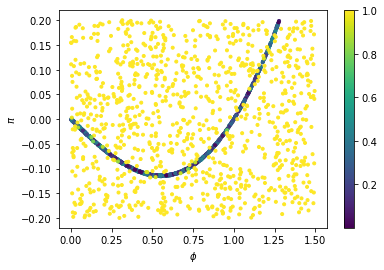

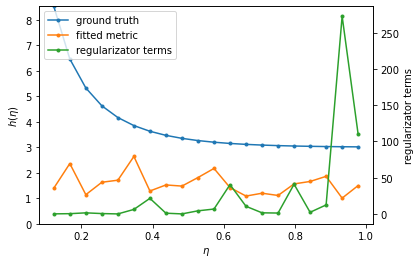

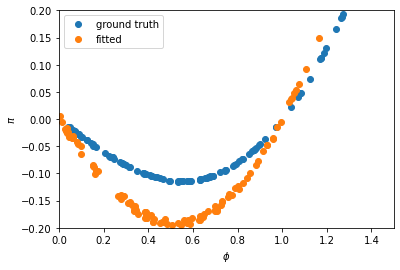

In [176]:
def get_AdS_Schwarzschild_metric(etas_mid):
    hs=d/torch.tanh(d*etas_mid)
    return hs

def generate_data(hs,N_data=1000,seed=None):
    if seed is not None: torch.manual_seed(seed)
    phi0=torch.rand(N_data)*1.5
    pi0=torch.rand(N_data)*.4-.2
    phi,pi=forward(phi0,pi0,hs)
    y=classify_final_data(phi,pi)
    return phi0,pi0,y

def generate_positive_data(hs,N_positive_data=1000,N_negative_data=1000,seed=None,use_tqdm=True,max_iter=25,N_test_data=None):
    if seed is not None: torch.manual_seed(seed)
    # generate data
    # collect positive one into an array. positive means y<.5
    # repeat the process until we have enough positive data
    if N_test_data is None: N_test_data=(N_positive_data+N_negative_data)*10
    phi0,pi0,y=generate_data(hs,N_data=N_test_data,seed=seed)
    phi0_positive,pi0_positive,y_positive=phi0[y<.5],pi0[y<.5],y[y<.5]
    phi0_negative,pi0_negative,y_negative=phi0[y>=.5],pi0[y>=.5],y[y>=.5]
    phi0_positive,pi0_positive,y_positive=phi0_positive[:N_positive_data],pi0_positive[:N_positive_data],y_positive[:N_positive_data]
    phi0_negative,pi0_negative,y_negative=phi0_negative[:N_negative_data],pi0_negative[:N_negative_data],y_negative[:N_negative_data]
    if use_tqdm: pbar=tqdm(total=N_positive_data)
    for i in range(max_iter):
        if len(phi0_positive)>=N_positive_data and len(phi0_negative)>=N_negative_data:
            break
        phi0,pi0,y=generate_data(hs,N_data=N_test_data,seed=None)
        phi0_positive=torch.cat([phi0_positive,phi0[y<.5]])
        pi0_positive=torch.cat([pi0_positive,pi0[y<.5]])
        y_positive=torch.cat([y_positive,y[y<.5]])
        phi0_negative=torch.cat([phi0_negative,phi0[y>=.5]])
        pi0_negative=torch.cat([pi0_negative,pi0[y>=.5]])
        y_negative=torch.cat([y_negative,y[y>=.5]])
        phi0_positive,pi0_positive,y_positive=phi0_positive[:N_positive_data],pi0_positive[:N_positive_data],y_positive[:N_positive_data]
        phi0_negative,pi0_negative,y_negative=phi0_negative[:N_negative_data],pi0_negative[:N_negative_data],y_negative[:N_negative_data]
        
        if use_tqdm: pbar.update(len(phi0_positive)-pbar.n)
    phi0,pi0,y=torch.cat([phi0_positive,phi0_negative]),torch.cat([pi0_positive,pi0_negative]),torch.cat([y_positive,y_negative])
    return phi0,pi0,y



hs_ground_truth=get_AdS_Schwarzschild_metric(etas_mid)

print('generating training data...')
phi0,pi0,y=generate_positive_data(hs_ground_truth,1000,1000)
print('Num of positive data:',torch.sum(y<.5))
print('Num of negative data:',torch.sum(y>=.5))
plt.scatter(_toN(phi0),_toN(pi0),c=_toN(y),cmap='viridis',marker='.')
plt.colorbar()
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\pi$')
plt.show()


def verify(hs):
    fig,ax1=plt.subplots()
    ax1.plot(_toN(etas_mid),_toN(hs_ground_truth),'.-',label='ground truth')
    ax1.plot(_toN(etas_mid),_toN(hs),'.-',label='fitted metric')
    ax1.set_xlabel(r'$\eta$')
    ax1.set_ylabel(r'$h(\eta)$')
    ax1.set_ylim(0,max(_toN(hs_ground_truth)))
    ax2=plt.twinx()
    ax2.plot(_toN(etas_mid),_toN(get_regularizator_terms(hs)),'.-',label='regularizator terms',color='C2')
    ax2.set_ylabel(r'regularizator terms')
    handles=[ax1.get_lines()[0],ax1.get_lines()[1],ax2.get_lines()[0]]
    labels=[h.get_label() for h in handles]
    plt.legend(handles,labels)


    plt.show()


    data_ground_truth=generate_positive_data(hs_ground_truth,100,0,seed=0,use_tqdm=False,N_test_data=1000)
    data_initial_guess=generate_positive_data(hs,100,0,seed=0,use_tqdm=False,N_test_data=1000)

    plt.plot(_toN(data_ground_truth[0]),_toN(data_ground_truth[1]),'o',label='ground truth')
    plt.plot(_toN(data_initial_guess[0]),_toN(data_initial_guess[1]),'o',label='fitted')
    plt.legend()
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$\pi$')
    plt.xlim(0,1.5)
    plt.ylim(-.2,.2)
    plt.show()


loghs=torch.nn.Parameter(torch.rand(len(etas_mid)))
verify(torch.exp(loghs))

  0%|          | 0/2000 [00:00<?, ?it/s]

step 0 loss 0.2682721637364361


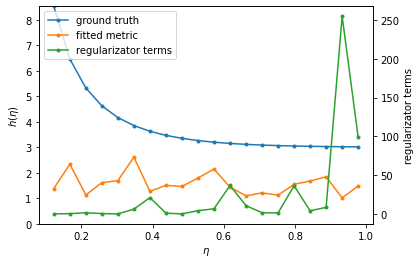

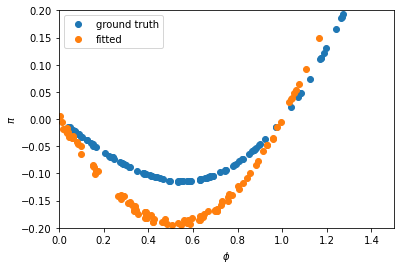

step 100 loss 0.23485497777558742


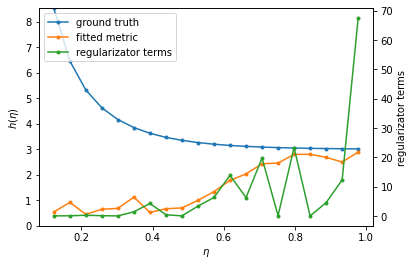

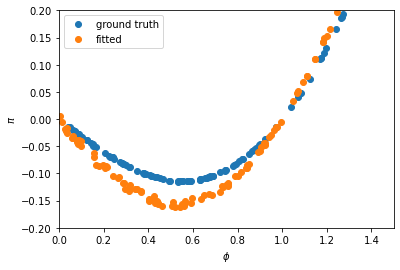

step 200 loss 0.03447803628257267


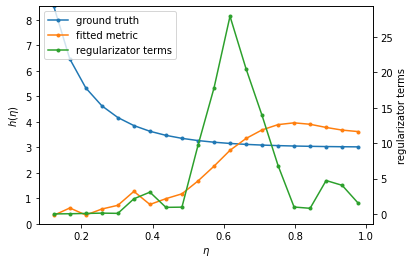

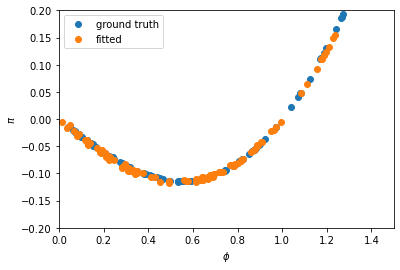

step 300 loss 0.02508935946489553


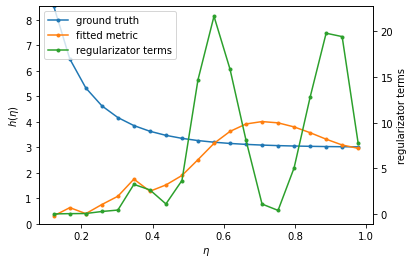

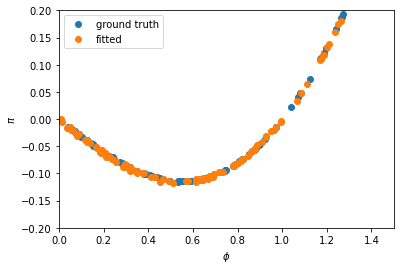

step 400 loss 0.02016459152691001


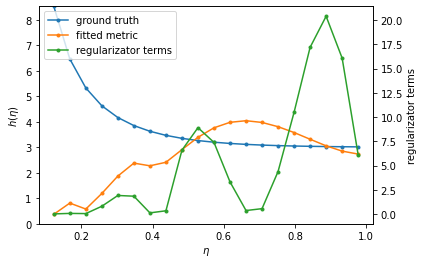

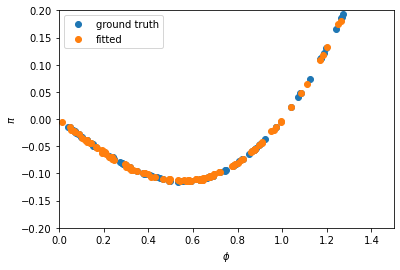

step 500 loss 0.007435376902352333


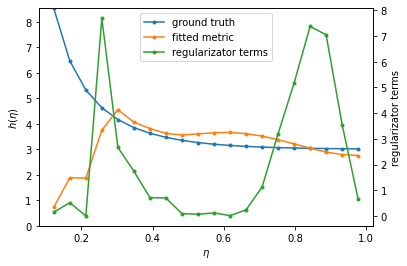

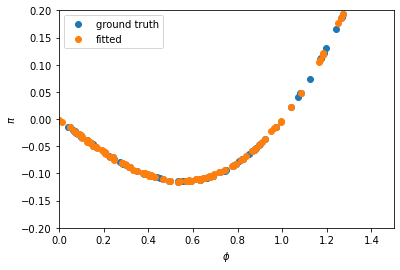

step 600 loss 0.0003884084015727235


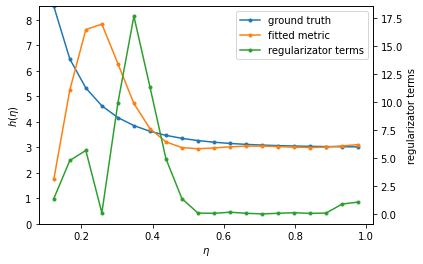

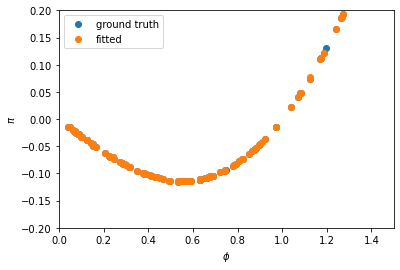

step 700 loss 0.0002512200605144708


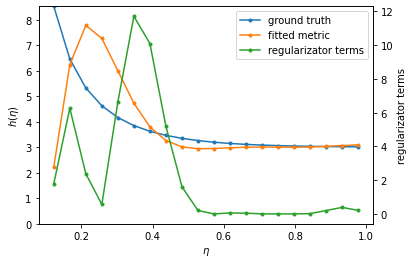

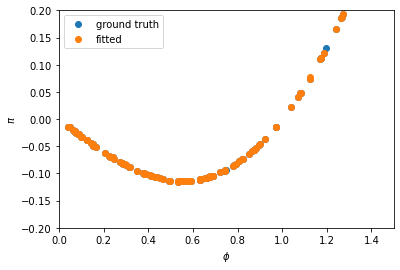

step 800 loss 0.00023503243254799084


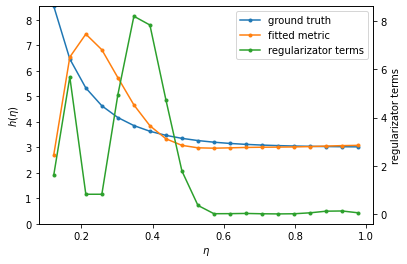

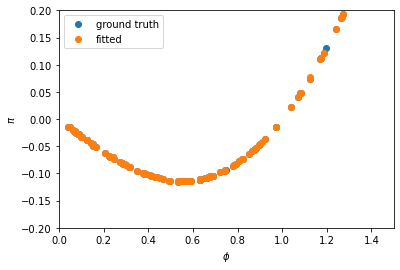

step 900 loss 0.00015900721913100072


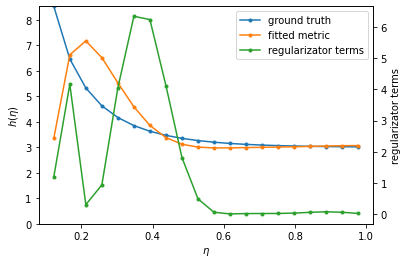

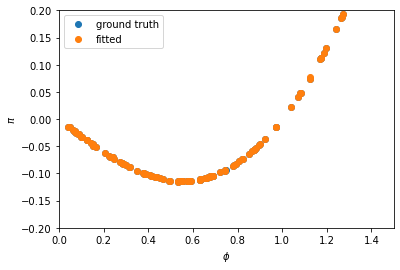

step 1000 loss 0.00012627119688050838


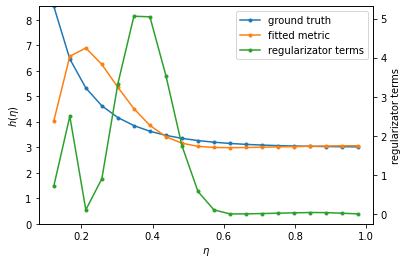

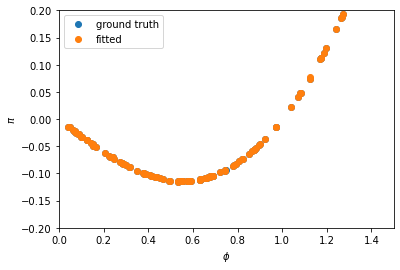

step 1100 loss 0.0001033877014142545


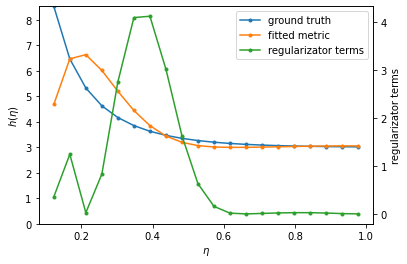

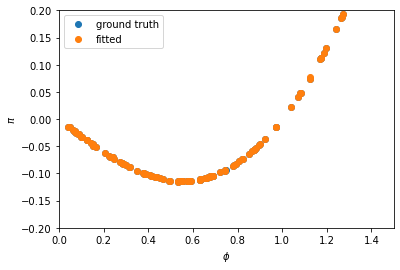

step 1200 loss 9.006351246024123e-05


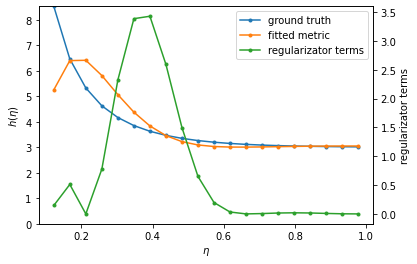

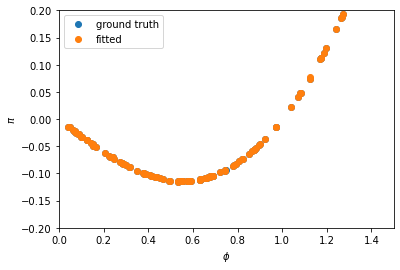

step 1300 loss 0.0001280678218222861


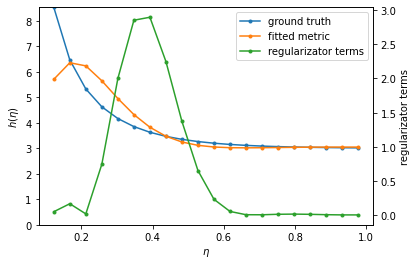

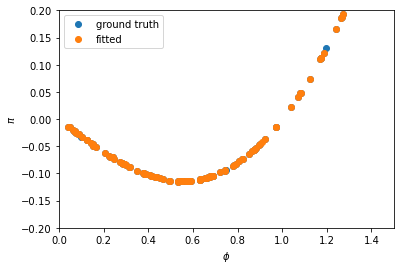

step 1400 loss 0.00010500730301607041


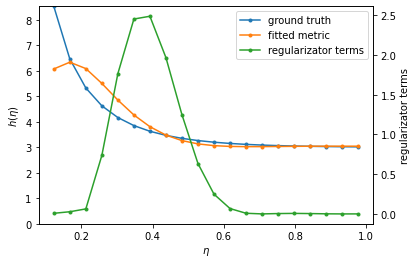

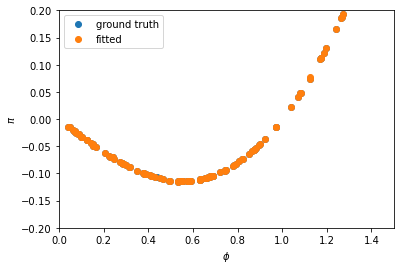

step 1500 loss 0.00017742900345533118


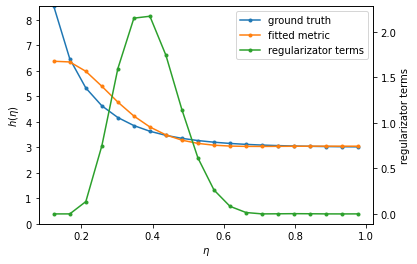

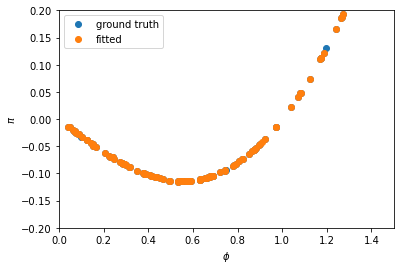

step 1600 loss 9.320886770938288e-05


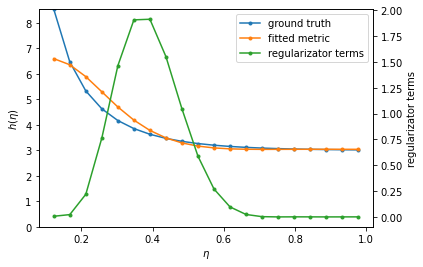

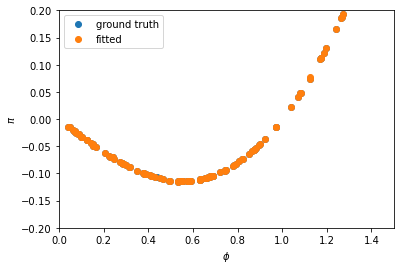

step 1700 loss 5.802754867831961e-05


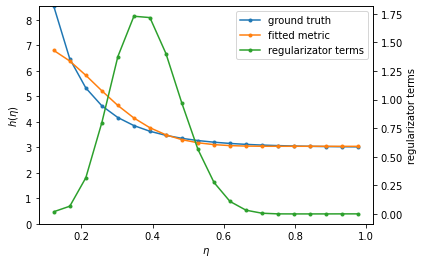

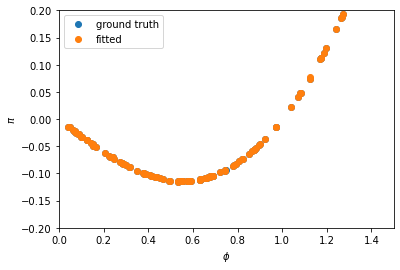

step 1800 loss 7.594880670346558e-05


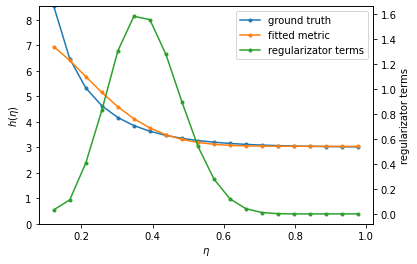

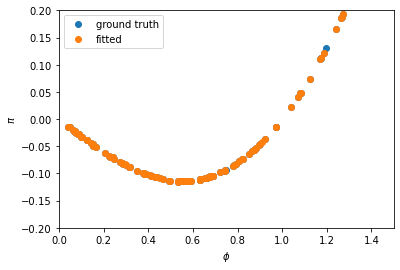

step 1900 loss 4.473970440405396e-05


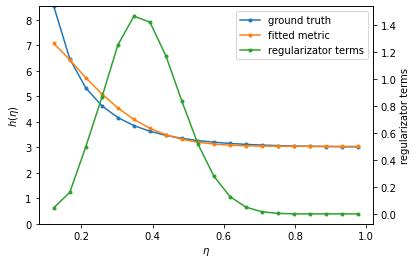

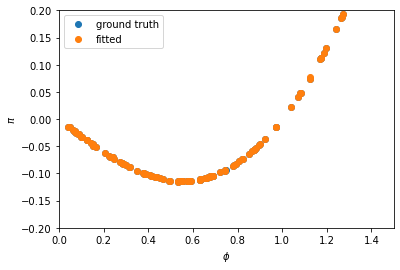

In [177]:
# train the metric hs from our data phi0,pi0,y
from torch import optim

# random in 0.1-4
optimizer=optim.Adam([loghs],lr=1e-2)
for i in tqdm(range(2000)):
    optimizer.zero_grad()
    loss=get_loss(phi0,pi0,y,torch.exp(loghs))
    loss.backward()
    optimizer.step()
    if i%100==0:
        print('step',i,'loss',loss.item())
        verify(torch.exp(loghs))